In [14]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


In [ ]:
# Model parameters  
C_m     = 1.0       # membrane capacitance (µF/cm²)  
gNa_max = 120.0     # max. Na conductance (mS/cm²)  
gK_max  = 36.0      # max. K conductance (mS/cm²)  
gL_max  = 0.3       # leak conductance (mS/cm²)  
ENa, EK, EL = 50.0, -77.0, -54.387  # reversal potentials (mV)

# Time grid  
t_start, t_end, dt = 0.0, 450.0, 0.01  # ms  
t = np.arange(t_start, t_end, dt)

# Current‑clamp command  
I_amp, I_delay, I_dur = 10.0, 100.0, 100.0  # µA/cm², ms  
def I_command(t):  
    """Return command current for current‑clamp."""  
    return I_amp * ((t >= I_delay) & (t < I_delay + I_dur))

# Voltage‑clamp command  
vc_delay, vc_dur = 10.0, 30.0   # ms  
V_hold, V_step, V_return = -65.0, 10.0, -65.0  # mV  
V_command = np.where(  
    t < vc_delay, V_hold,  
    np.where(t < vc_delay + vc_dur, V_step, V_return)  
)

# Gating kinetics (alpha & beta functions)  
def alpha_m(V): return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0)/10.0))  
def beta_m(V):  return 4.0*np.exp(-(V+65.0)/18.0)  
def alpha_h(V): return 0.07*np.exp(-(V+65.0)/20.0)  
def beta_h(V):  return 1.0/(1.0 + np.exp(-(V+35.0)/10.0))  
def alpha_n(V): return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0)/10.0))  
def beta_n(V):  return 0.125*np.exp(-(V+65.0)/80.0)

# Conductances & ionic currents  
def gNa(m, h):   return gNa_max * m**3 * h  
def gK(n):       return gK_max  * n**4  
def gL():        return gL_max  
def I_Na(V, m, h): return gNa(m, h)*(V - ENa)  
def I_K(V, n):     return gK(n)*(V - EK)  
def I_L(V):        return gL()*(V - EL)

# Compute resting steady‑state gating at resting potential (EL)
V_rest = EL  
m_rest = alpha_m(V_rest) / (alpha_m(V_rest) + beta_m(V_rest))  
h_rest = alpha_h(V_rest) / (alpha_h(V_rest) + beta_h(V_rest))  
n_rest = alpha_n(V_rest) / (alpha_n(V_rest) + beta_n(V_rest))  
X0 = [V_rest, m_rest, h_rest, n_rest]


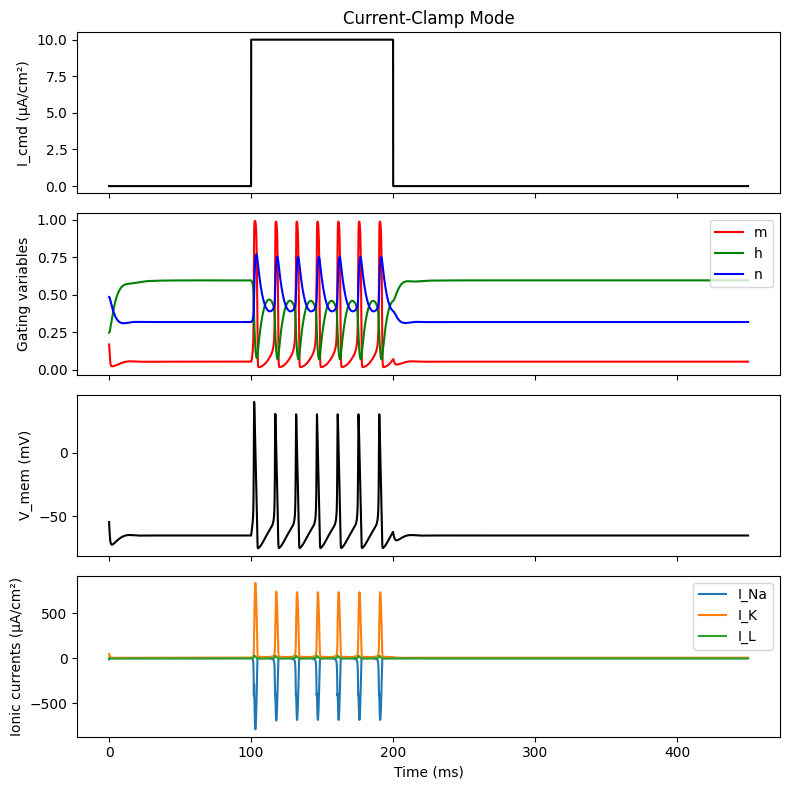

In [ ]:
def dXdt_current_clamp(X, t):
    """ODEs for current‐clamp: apply I_command, let V evolve."""
    V, m, h, n = X
    I_ion = I_Na(V, m, h) + I_K(V, n) + I_L(V)
    dVdt = (I_command(t) - I_ion) / C_m
    dmdt = alpha_m(V)*(1 - m) - beta_m(V)*m
    dhdt = alpha_h(V)*(1 - h) - beta_h(V)*h
    dndt = alpha_n(V)*(1 - n) - beta_n(V)*n
    return [dVdt, dmdt, dhdt, dndt]

# Integrate the system
sol_cc = odeint(dXdt_current_clamp, X0, t)
V_mem_cc, m_cc, h_cc, n_cc = sol_cc.T

# Command current & ionic currents
I_cmd_cc = I_command(t)
I_Na_cc  = I_Na(V_mem_cc, m_cc, h_cc)
I_K_cc   = I_K(V_mem_cc, n_cc)
I_L_cc   = I_L(V_mem_cc)

# Plot
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

ax[0].plot(t, I_cmd_cc, 'k')
ax[0].set_ylabel('I_cmd (µA/cm²)')
ax[0].set_title('Current‑Clamp Mode')

ax[1].plot(t, m_cc, 'r', label='m')
ax[1].plot(t, h_cc, 'g', label='h')
ax[1].plot(t, n_cc, 'b', label='n')
ax[1].set_ylabel('Gating variables')
ax[1].legend(loc='upper right')

ax[2].plot(t, V_mem_cc, 'k')
ax[2].set_ylabel('V_mem (mV)')

ax[3].plot(t, I_Na_cc, label='I_Na')
ax[3].plot(t, I_K_cc,  label='I_K')
ax[3].plot(t, I_L_cc,  label='I_L')
ax[3].set_ylabel('Ionic currents (µA/cm²)')
ax[3].legend(loc='upper right')

ax[3].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()


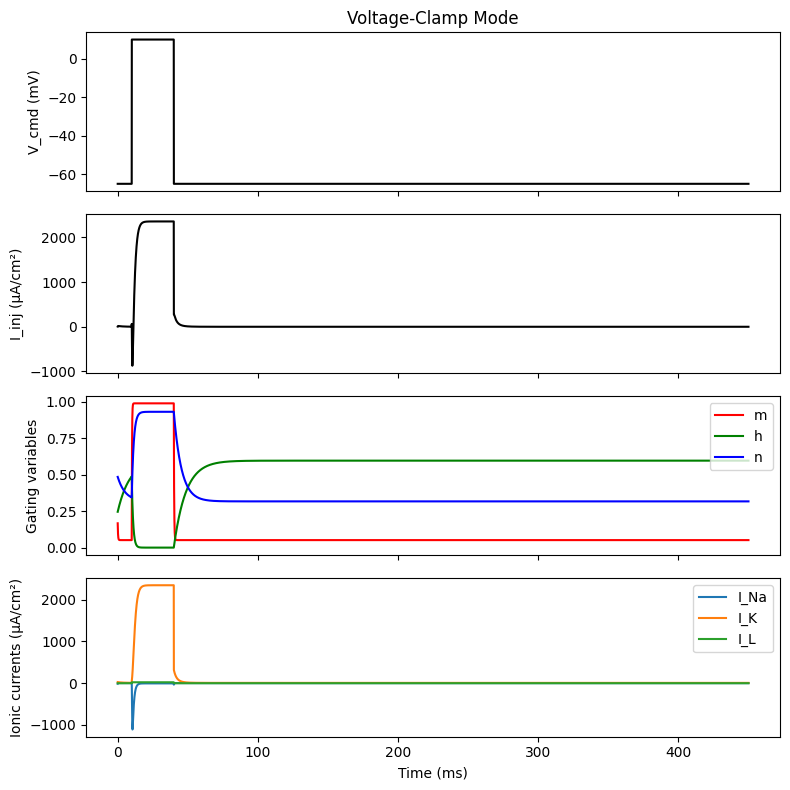

In [ ]:
# Preallocate gating arrays
m_vc = np.zeros_like(t)
h_vc = np.zeros_like(t)
n_vc = np.zeros_like(t)
m_vc[0], h_vc[0], n_vc[0] = m_rest, h_rest, n_rest

# Euler‐step gating under voltage clamp (V fixed to V_command)
for i in range(1, len(t)):
    V_prev = V_command[i-1]
    dm = alpha_m(V_prev)*(1 - m_vc[i-1]) - beta_m(V_prev)*m_vc[i-1]
    dh = alpha_h(V_prev)*(1 - h_vc[i-1]) - beta_h(V_prev)*h_vc[i-1]
    dn = alpha_n(V_prev)*(1 - n_vc[i-1]) - beta_n(V_prev)*n_vc[i-1]
    m_vc[i] = m_vc[i-1] + dm*dt
    h_vc[i] = h_vc[i-1] + dh*dt
    n_vc[i] = n_vc[i-1] + dn*dt

# Compute total clamp current and individual ionic currents
I_inj       = I_Na(V_command, m_vc, h_vc) + I_K(V_command, n_vc) + I_L(V_command)
I_Na_vc     = I_Na(V_command, m_vc, h_vc)
I_K_vc      = I_K(V_command, n_vc)
I_L_vc      = I_L(V_command)

# Plot
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

ax[0].plot(t, V_command, 'k')
ax[0].set_ylabel('V_cmd (mV)')
ax[0].set_title('Voltage‑Clamp Mode')

ax[1].plot(t, I_inj, 'k')
ax[1].set_ylabel('I_inj (µA/cm²)')

ax[2].plot(t, m_vc, 'r', label='m')
ax[2].plot(t, h_vc, 'g', label='h')
ax[2].plot(t, n_vc, 'b', label='n')
ax[2].set_ylabel('Gating variables')
ax[2].legend(loc='upper right')

ax[3].plot(t, I_Na_vc, label='I_Na')
ax[3].plot(t, I_K_vc,  label='I_K')
ax[3].plot(t, I_L_vc,  label='I_L')
ax[3].set_ylabel('Ionic currents (µA/cm²)')
ax[3].legend(loc='upper right')

ax[3].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()
